### Goal
To build a model for predicting a price for apartments and condominiums in Singapore.

##### Task for current workbook:
- Convert raw data into a format proper for further analysis and processing

### Data
We have historical transaction data from:
- https://www.ura.gov.sg/property-market-information/pmiResidentialTransactionSearch
- Please note that the data from the website above is subject to copyright protection and cannot be used other than for personal purposes without prior permission of the copyright holder. Please visit https://www.ura.gov.sg for further information

In [1]:
import pandas as pd
import numpy as np
import os
import dateutil
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)  
np.set_printoptions(threshold=np.inf)
sns.set()
tqdm.pandas()

DAYS_IN_YEAR = 365.2425
data_path="data/"
trn_path=data_path+"trn_1/"


### Importing files

- Important: please ignore this section unless you need to reload the files. Proceed to "Upload dataframe"
- Importnat: due to the copyrights described above, we do not provide the original source files with data. Please use the dataframe file in the next section as a source file.

In [146]:
# fps = os.listdir(trn_path)
# fps = [f for f in fps if not f.startswith(".")]
# df = pd.read_csv(trn_path+fps[0])
# for i in range(1, len(fps)):
#     print("Reading: ", trn_path+fps[i])
#     df_temp = pd.read_csv(trn_path+fps[i])
#     df = pd.concat([df, df_temp], ignore_index=True)

Reading:  data/trn_1/ResidentialTransaction20230720120431.csv
Reading:  data/trn_1/ResidentialTransaction20230720131049.csv
Reading:  data/trn_1/ResidentialTransaction20230720131200.csv
Reading:  data/trn_1/ResidentialTransaction20230720131313.csv
Reading:  data/trn_1/ResidentialTransaction20230720131807.csv
Reading:  data/trn_1/ResidentialTransaction20230720133831.csv
Reading:  data/trn_1/ResidentialTransaction20230720133953.csv
Reading:  data/trn_1/ResidentialTransaction20230720134106.csv
Reading:  data/trn_1/ResidentialTransaction20230720134227.csv


In [147]:
# df.to_csv(data_path+"0_raw_data.csv", index=False)

### Uploading dataframe

Important:
- the data in this dataset is likely subject to the copyright protection as described above. It is presented here only with the purpose of demonstrating the algorithms in this work book.
- <font color='red'>You not allowed to reuse this data for any other purpoese. If you need this data, please visit https://www.ura.gov.sg</font>

In [151]:
df = pd.read_csv(data_path+"0_raw_data.csv")

### Data review

In [152]:
df.head(5)

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Street Name,Type of Sale,Type of Area,Area (SQM),Unit Price ($ PSM),Nett Price($),Property Type,Number of Units,Tenure,Postal District,Market Segment,Floor Level
0,CAVAN SUITES,"600,000",355.21,"1,689",Jul-23,CAVAN ROAD,Resale,Strata,33,"18,182",-,Apartment,1,Freehold,8,Rest of Central Region,01 to 05
1,THE CLEARWATER,"1,670,000","1,377.79","1,212",Jul-23,BEDOK RESERVOIR VIEW,Resale,Strata,128,"13,047",-,Condominium,1,99 yrs lease commencing from 1997,16,Outside Central Region,01 to 05
2,SHERWOOD CONDOMINIUM,"1,370,000",925.7,"1,480",Jul-23,JALAN JURONG KECHIL,Resale,Strata,86,"15,930",-,Condominium,1,Freehold,21,Rest of Central Region,06 to 10
3,AALTO,"3,488,000","1,528.49","2,282",Jul-23,MEYER ROAD,Resale,Strata,142,"24,563",-,Condominium,1,Freehold,15,Rest of Central Region,01 to 05
4,FERRARIA PARK CONDOMINIUM,"1,488,000","1,302.44","1,142",Jul-23,FLORA DRIVE,Resale,Strata,121,"12,298",-,Condominium,1,Freehold,17,Outside Central Region,01 to 05


In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99930 entries, 0 to 99929
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Project Name          99930 non-null  object
 1   Transacted Price ($)  99930 non-null  object
 2   Area (SQFT)           99930 non-null  object
 3   Unit Price ($ PSF)    99930 non-null  object
 4   Sale Date             99930 non-null  object
 5   Street Name           99930 non-null  object
 6   Type of Sale          99930 non-null  object
 7   Type of Area          99930 non-null  object
 8   Area (SQM)            99930 non-null  object
 9   Unit Price ($ PSM)    99930 non-null  object
 10  Nett Price($)         99930 non-null  object
 11  Property Type         99930 non-null  object
 12  Number of Units       99930 non-null  int64 
 13  Tenure                99930 non-null  object
 14  Postal District       99930 non-null  int64 
 15  Market Segment        99930 non-null

In [154]:
for c in df.columns:
    print(c, df[c].nunique())

Project Name 2245
Transacted Price ($) 16691
Area (SQFT) 580
Unit Price ($ PSF) 3373
Sale Date 61
Street Name 838
Type of Sale 3
Type of Area 2
Area (SQM) 580
Unit Price ($ PSM) 23388
Nett Price($) 363
Property Type 2
Number of Units 29
Tenure 116
Postal District 27
Market Segment 3
Floor Level 17


##### Categorical variables
Some of the categorical variables lead to high dimensionality:
- project name (2000+ categories)
- street name (800+ categories)</t>

It does not make sense to use them directly in a regression model. However, we can apply dimensionality reduction techniques (PCA). Also we may transform street and project data to geographical coordinates.

##### Modifying columns
- Square feet and square meters. 
        - Area: sqft and sqm; 
        - Unit price
    - We shall leave only square feet, delete square meters. Before that make sure that the relationship between sqm and sqft is consistent across all entries. Eliminate the entries where the relationship does not hold.</t>

- Transacted price and net price. From the description at the source website, the net price is the price after certains discounts given. Therefore, we have to generate the column where the price for every transaction is the final one. We will use this column for further tasks.

- Number of units. Some transactions include more that one apartment or condominium unit. The area given in the dataset is thefor all units. For the purpose of price prediction, we can calculate a column "square feet per unit". For most of the transactions where only one unit is involed, it will be the same as Area SQFT. For the multiple unit transactions the value will be the average calculated as the total area divided by the number of units. After that the Number of Units column can be dropped.

- Transaction date. We need to convert it to datetime. As the precision of the date is one month, we will set day equal to 1 for all transactions. Also, for simplicity of operating with months and years, we will make separate columns for month (1-12) and for years. The original column with datetime will be kept for time series calculations.

- Tenure. This is a textual column having the value "Freehold" for freehold properties or common pattern like "99 yrs lease commencing from 1997". We will split the column into separate columns for tenure type, tenure start year, tenure years, tenure ending year, and tenure remaining years.

- Floor level. This is a textual column having values with the pattern "01 to 05", "06 to 10", etc. In order to use it for regression models, we will extract the numbers from the strings and take the median value of the two numbers as an approximation for the floor.
- Also we will calculate the highest floor for each project and save it in the new column "max_floor" as the higher rise buildings may indicate the premium developments which will impact the price. 


##### Target structure of dataset
- project_name
- street_name
- postal_district
- latitude (NEW)
- longitude (NEW)
- area_sqft_per_unit
- sale_date
- sale_month
- sale_year
- type_sale
- type_area
- type_property
- market_segment
- tenure_type
- tenure_start_year (for leasehold analysis only)
- tenure_end_year (for leasehold analysis only)
- tenure_remained (for leasohold analysis only)
- floor_level
- max_floor (NEW)
- price_sqft (dependent variable)


##### Steps
- Modify column names for easier coding
- Convert the following to numeric format: price, area, number of units
- Convert sale date column to datetime
- Test if there are any inconsistencies between square feet and square meters columns. If the relationship between sqft and sqm is abnormal in some cases, we shall remove those transactions as the data may be corrupted. Remove sqare meters columns.
- Adjust area column for multi-unit sales
- Split tenure column to separate columns
- Convert floor level column to a number
- Generate max_floor column based on project
- Retrieve geographical coordinates for every street or project, whichever is available

- Rearrange the column order

#### Modifying column names

In [155]:
df.columns

Index(['Project Name', 'Transacted Price ($)', 'Area (SQFT)',
       'Unit Price ($ PSF)', 'Sale Date', 'Street Name', 'Type of Sale',
       'Type of Area', 'Area (SQM)', 'Unit Price ($ PSM)', 'Nett Price($)',
       'Property Type', 'Number of Units', 'Tenure', 'Postal District',
       'Market Segment', 'Floor Level'],
      dtype='object')

In [156]:
df.columns = ['project_name', 'trn_price_sgd', 'area_sqft',
       'price_sqft', 'sale_date', 'street', 'sale_type',
       'area_type', 'area_sqm', 'price_sqm', 'net_price',
       'property_type', 'n_units', 'tenure', 'postal_district',
       'mkt_segment', 'floor_level']

In [157]:
df_copy = df.copy()

#### Project_name variable

In [158]:
print(df.project_name.nunique())

2245


- Check if there are any transactions with properties without project name or with invalid name:

In [159]:
df.project_name.unique()

array(['CAVAN SUITES', 'THE CLEARWATER', 'SHERWOOD CONDOMINIUM', 'AALTO',
       'FERRARIA PARK CONDOMINIUM', 'SKY VUE', 'TROPICAL SPRING',
       '368 THOMSON', 'SAVANNAH CONDOPARK', 'MONARCHY APARTMENTS',
       'WATERSCAPE AT CAVENAGH', 'THE TRE VER', 'STARVILLE',
       'WATERFRONT ISLE', 'HEDGES PARK CONDOMINIUM',
       'THE GARDEN RESIDENCES', 'THE GRANGE', 'THE PANORAMA',
       'DUBLIN ROAD FLATS', 'BALLOTA PARK CONDOMINIUM', 'JADESCAPE',
       'AFFINITY AT SERANGOON', 'GLENDALE PARK', 'ECO',
       'HILLVIEW REGENCY', 'ASTOR GREEN', 'BOTANNIA', 'THE LEVELZ',
       'SOUTHAVEN I', 'RIVERFRONT RESIDENCES',
       'KENT RIDGE HILL RESIDENCES', 'ONE-NORTH RESIDENCES', 'CYAN',
       'THE CENTRIS', 'THE NAUTICAL', 'THE LUXURIE',
       'WING ON LIFE GARDEN', 'TREASURE AT TAMPINES', 'MAYFAIR GARDENS',
       'SOUTHBANK', 'THE CONTINUUM', 'ONE BERNAM', 'ONE PEARL BANK',
       'CAIRNHILL 16', 'THE RESERVE RESIDENCES', 'IRWELL HILL RESIDENCES',
       'SCENECA RESIDENCE', 'PICCADILL

In [160]:
df.project_name.apply(len).min()

2

In [161]:
df[df.project_name.apply(lambda x: len(x) < 4)]['project_name'].unique()

array(['ECO', 'M66', 'M5', 'M21', 'JIA'], dtype=object)

In [162]:
df[df.project_name.apply(lambda x: len(x) < 3)]['project_name'].unique()

array(['M5'], dtype=object)

Conclusion:
- there is no transactions with properties (apartments or condominiums) where there is no project or project name is invalid

#### Street variable

- Check if there are any cases when street name is invalid:

In [163]:
print(df.street.nunique())

838


In [164]:
df.street.apply(len).min()

8

In [165]:
df[df.street.apply(lambda x: len(x) < 9)]['street'].unique()

array(['COVE WAY', 'AVA ROAD', 'NIM ROAD'], dtype=object)

There is likely no properties without proper street name

#### Convert numeric columns to a numeric format

In [166]:
numeric_cols = ['trn_price_sgd', 'area_sqft',
       'price_sqft', 'area_sqm', 'price_sqm']

In [167]:
for nc in numeric_cols:
    df[nc] = df[nc].progress_apply(lambda x: float(x.replace(',', '')))

100%|██████████| 99930/99930 [00:00<00:00, 469289.27it/s]


In [168]:
df['net_price'] =\
df.apply(lambda x: x['trn_price_sgd'] if x['net_price'] == '-' else float(x['net_price'].replace(',', '')), axis=1)

#### Sale date to datetime, separate columns for month and year

In [169]:
def transform_date(date_str):
    month_str = date_str[:3]
    year_str = '20'+date_str[-2:]
    date_str = year_str + '-' + month_str + '-' + '01'
    return dateutil.parser.parse(date_str, yearfirst=True)

In [170]:
df.sale_date = df.sale_date.progress_apply(transform_date)

100%|██████████| 99930/99930 [00:08<00:00, 12091.37it/s]


In [171]:
df['sale_month'] = df.sale_date.progress_apply(lambda x: x.month)

100%|██████████| 99930/99930 [00:00<00:00, 151549.88it/s]


In [172]:
df['sale_year'] = df.sale_date.progress_apply(lambda x: x.year)

100%|██████████| 99930/99930 [00:00<00:00, 146747.64it/s]


In [173]:
df.sale_year.unique()

array([2023, 2022, 2021, 2020, 2019, 2018])

#### Square feet and square meters

- Check the consistency of the relationship between square feet and square meters:

In [174]:
print((df.area_sqft / df.area_sqm).min())
print((df.area_sqft / df.area_sqm).max())

10.763870967741935
10.764166666666666


The relationship between sqft and sqm holds for all transactions. Sqm can be safely deleted

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99930 entries, 0 to 99929
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   project_name     99930 non-null  object        
 1   trn_price_sgd    99930 non-null  float64       
 2   area_sqft        99930 non-null  float64       
 3   price_sqft       99930 non-null  float64       
 4   sale_date        99930 non-null  datetime64[ns]
 5   street           99930 non-null  object        
 6   sale_type        99930 non-null  object        
 7   area_type        99930 non-null  object        
 8   area_sqm         99930 non-null  float64       
 9   price_sqm        99930 non-null  float64       
 10  net_price        99930 non-null  float64       
 11  property_type    99930 non-null  object        
 12  n_units          99930 non-null  int64         
 13  tenure           99930 non-null  object        
 14  postal_district  99930 non-null  int64

- Checking the consistency of price per sqft from the original dataset and the calculated values:

In [176]:
price_error = (df.net_price / df.area_sqft) - df.price_sqft

In [177]:
df[abs(price_error) > 1]

,project_name,trn_price_sgd,area_sqft,price_sqft,sale_date,street,sale_type,area_type,area_sqm,price_sqm,net_price,property_type,n_units,tenure,postal_district,mkt_segment,floor_level,sale_month,sale_year


There is no cases of inconsistency.
- 'trn_price_sgd' and 'net_price' can be removed

In [178]:
df.drop(columns = ['trn_price_sgd', 'area_sqm', 'price_sqm', 'net_price'], inplace=True)

#### Multiple units transactions

Let's check whether the price_sqf for multiple unit sales is significantly different from the prices for properties in the same projects for the same years

In [179]:
print(df.n_units.min())
print(df.n_units.max()) #no zeros or na

1
446


In [180]:
multi_unit_sales = df[df.n_units > 1]
multi_unit_sales_projects = multi_unit_sales.project_name.unique().tolist()

In [181]:
len(multi_unit_sales.index)

53

In [182]:
len(multi_unit_sales_projects)

38

In [183]:
single_unit_sales = df[(df.n_units == 1) & (df.project_name.isin(multi_unit_sales_projects))]

In [184]:
len(single_unit_sales)

1038

Note:
- there are 53 multi-unit transactions related to 38 projects.
- the number of single-unit transactions related to those 38 projects is over 1000.
- Therefore, consider removing the multi-unit sales from the dataset if their statistical properties differ significantly from the single unit sales

Checking statistical distributions of price_sqft for single and multiple unit sales:

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


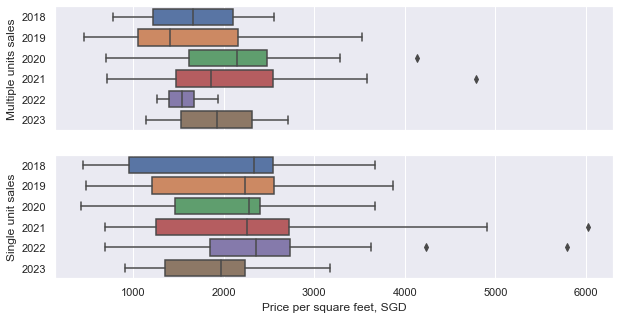

In [192]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), sharex=True)
sns.boxplot(ax=axes[0], data=multi_unit_sales, x='price_sqft', y='sale_year', orient='h')
axes[0].set_ylabel("Multiple units sales")
axes[0].set_xlabel("")
sns.boxplot(ax=axes[1], data=single_unit_sales, x='price_sqft', y='sale_year', orient='h')
axes[1].set_ylabel("Single unit sales")
axes[1].set_xlabel("Price per square feet, SGD")
fig.show()

Statistical parameters for single and multi unit sales look quite different.
 <br>
=>Therefore, remove multi-unit sales from the dataset

In [193]:
df = df[df.n_units == 1]

In [194]:
df.drop(columns=['n_units'], inplace=True)

#### Splitting tenure column to separate columns

In [195]:
df.tenure.head(5)

0                             Freehold
1    99 yrs lease commencing from 1997
2                             Freehold
3                             Freehold
4                             Freehold
Name: tenure, dtype: object

In [196]:
df.tenure.unique()

array(['Freehold', '99 yrs lease commencing from 1997',
       '99 yrs lease commencing from 2013',
       '99 yrs lease commencing from 2000',
       '99 yrs lease commencing from 2018',
       '99 yrs lease commencing from 2009',
       '99 yrs lease commencing from 2010',
       '99 yrs lease commencing from 2017',
       '99 yrs lease commencing from 2012',
       '99 yrs lease commencing from 1991',
       '956 yrs lease commencing from 1928',
       '99 yrs lease commencing from 1994',
       '99 yrs lease commencing from 2005',
       '99 yrs lease commencing from 2006',
       '99 yrs lease commencing from 2011',
       '99 yrs lease commencing from 2019',
       '99 yrs lease commencing from 2021',
       '99 yrs lease commencing from 2020', '99 years leasehold',
       '99 yrs lease commencing from 2015',
       '99 yrs lease commencing from 1998',
       '99 yrs lease commencing from 2014',
       '99 yrs lease commencing from 1996',
       '999 yrs lease commencing from 187

In [197]:
#There is a value '99 years leasehold' without reference to the starting year
df[df.tenure=='99 years leasehold']

,project_name,area_sqft,price_sqft,sale_date,street,sale_type,area_type,property_type,tenure,postal_district,mkt_segment,floor_level,sale_month,sale_year
52,LENTOR HILLS RESIDENCES,753.48,2219.0,2023-07-01,LENTOR HILLS ROAD,New Sale,Strata,Apartment,99 years leasehold,26,Outside Central Region,11 to 15,7,2023
54,LENTOR HILLS RESIDENCES,710.42,2234.0,2023-07-01,LENTOR HILLS ROAD,New Sale,Strata,Apartment,99 years leasehold,26,Outside Central Region,11 to 15,7,2023
55,LENTOR HILLS RESIDENCES,1119.46,2038.0,2023-07-01,LENTOR HILLS ROAD,New Sale,Strata,Apartment,99 years leasehold,26,Outside Central Region,11 to 15,7,2023
56,LENTOR HILLS RESIDENCES,688.90,2249.0,2023-07-01,LENTOR HILLS ROAD,New Sale,Strata,Apartment,99 years leasehold,26,Outside Central Region,11 to 15,7,2023
57,LENTOR HILLS RESIDENCES,958.00,2113.0,2023-07-01,LENTOR HILLS ROAD,New Sale,Strata,Apartment,99 years leasehold,26,Outside Central Region,11 to 15,7,2023
58,LENTOR HILLS RESIDENCES,958.00,2054.0,2023-07-01,LENTOR HILLS ROAD,New Sale,Strata,Apartment,99 years leasehold,26,Outside Central Region,11 to 15,7,2023
59,LENTOR HILLS RESIDENCES,753.48,2287.0,2023-07-01,LENTOR HILLS ROAD,New Sale,Strata,Apartment,99 years leasehold,26,Outside Central Region,16 to 20,7,2023
61,THE MYST,699.66,2101.0,2023-07-01,UPPER BUKIT TIMAH ROAD,New Sale,Strata,Condominium,99 years leasehold,23,Outside Central Region,06 to 10,7,2023
72,LENTOR HILLS RESIDENCES,742.72,1995.0,2023-07-01,LENTOR HILLS ROAD,New Sale,Strata,Apartment,99 years leasehold,26,Outside Central Region,01 to 05,7,2023
73,LENTOR HILLS RESIDENCES,753.48,2097.0,2023-07-01,LENTOR HILLS ROAD,New Sale,Strata,Apartment,99 years leasehold,26,Outside Central Region,01 to 05,7,2023


In [198]:
def extract_lease_info(input_string):
    import re
    from datetime import datetime
    import numpy as np
    
    pattern = r'(\d+)\s+yrs\s+lease\s+commencing\s+from\s+(\d{4})'
    match = re.search(pattern, input_string)
    
    if match:
        years_lease = int(match.group(1))
        commencing_year = int(match.group(2))
        commencing_date = datetime(commencing_year, 12, 31)  # Assuming December 31st of the commencing year
        return ('Lease', years_lease, commencing_date)
    else:
        if input_string.lower() == "freehold":
            return ('Freehold', np.nan, np.nan)
        else:
            return (input_string, np.nan, np.nan)

# Test the function with various input strings
input_string1 = "60 yrs lease commencing from 1977"
result1 = extract_lease_info(input_string1)
print(result1)  # Output: ('lease', 60, datetime.datetime(1977, 12, 31, 0, 0))

input_string2 = "Freehold"
result2 = extract_lease_info(input_string2)
print(result2)  # Output: ('Freehold', nan, nan)

input_string3 = "Random string"
result3 = extract_lease_info(input_string3)
print(result3)  # Output: ('Freehold', nan, nan)

#99 years leasehold
input_string4 = "99 years leasehold"
result4 = extract_lease_info(input_string4)
print(result4)  

('Lease', 60, datetime.datetime(1977, 12, 31, 0, 0))
('Freehold', nan, nan)
('Random string', nan, nan)
('99 years leasehold', nan, nan)


In [199]:
def years_remained(x):
#     print(x['tenure_years'], x['tenure_start'])
    if np.isnan(x['tenure_years']):
        return np.nan
    tenure_days = int(DAYS_IN_YEAR*x['tenure_years'])
    days_passed = (datetime.today() - x['tenure_start']).days
    days_remaining = tenure_days - days_passed
    y_remaining = round(days_remaining / DAYS_IN_YEAR, 1)
#     days = int(DAYS_IN_YEAR*x['tenure_years'])
#     print(days)
#     td = timedelta(days=days)
#     print(td)
#     end_date = x['tenure_start'] + timedelta(days = DAYS_IN_YEAR*x['tenure_years'])
    
#     y_remaining = round((end_date - datetime.today()).days / DAYS_IN_YEAR, 1)
    return y_remaining

In [200]:
def convert_tenure(x):
    tenure_type, tenure_years, tenure_start = extract_lease_info(x['tenure'])
    x['tenure_type'] = tenure_type
    x['tenure_years'] = tenure_years
    x['tenure_start'] = tenure_start
    
    x['tenure_remained'] = years_remained(x)
        
    return x

In [201]:
df = df.progress_apply(convert_tenure, axis=1) #! Time consuming, circa 6 min

100%|██████████| 99877/99877 [07:13<00:00, 230.47it/s]


In [202]:
def years_ago(x):
    if np.isnan(x['tenure_years']):
        return np.nan
    y_ago = x['sale_year'] - x['tenure_start'].year
    return y_ago

In [203]:
df.iloc[1]

project_name                          THE CLEARWATER
area_sqft                                    1377.79
price_sqft                                      1212
sale_date                        2023-07-01 00:00:00
street                          BEDOK RESERVOIR VIEW
sale_type                                     Resale
area_type                                     Strata
property_type                            Condominium
tenure             99 yrs lease commencing from 1997
postal_district                                   16
mkt_segment                   Outside Central Region
floor_level                                 01 to 05
sale_month                                         7
sale_year                                       2023
tenure_type                                    Lease
tenure_years                                      99
tenure_start                     1997-12-31 00:00:00
tenure_remained                                 73.4
Name: 1, dtype: object

In [204]:
years_ago(df.iloc[1])

26

In [205]:
df['tenure_start_y_ago'] = df.progress_apply(years_ago, axis=1)

100%|██████████| 99877/99877 [00:03<00:00, 29839.45it/s]


In [206]:
df.tenure_type.unique()

array(['Freehold', 'Lease', '99 years leasehold'], dtype=object)

Note: 
- some transactions have the description '99 years leasehold' without specifying the year when it started.
- We found out that these transactions relate only to two projects: 'LENTOR HILLS RESIDENCES' and 'THE MYST'
- Based on the internet search, both properies above  started in 2023. We shall make manual adjustment to our dataset.

In [207]:
leasehold_99_no_year = df[df['tenure_type'] == '99 years leasehold']

In [208]:
leasehold_99_no_year.project_name.unique()

array(['LENTOR HILLS RESIDENCES', 'THE MYST'], dtype=object)

In [209]:
df.tenure_years = df.apply(lambda x: x['tenure_years'] 
                                       if x['tenure_type'] != '99 years leasehold' else 99, axis=1)

In [210]:
df.tenure_start = df.apply(lambda x: x['tenure_start'] 
                                       if x['tenure_type'] != '99 years leasehold' else datetime(2023, 1, 1), axis=1)

In [211]:
df.tenure_remained = df.apply(lambda x: x['tenure_remained'] 
                                       if x['tenure_type'] != '99 years leasehold' else years_remained(x), axis=1)

In [212]:
df.tenure_start_y_ago = df.apply(lambda x: x['tenure_start_y_ago'] 
                                       if x['tenure_type'] != '99 years leasehold' else years_ago(x), axis=1)

In [213]:
#Test that there is no unexpected values for any of the tenure columns for the transactions with these two properties
print(df[df.tenure_type == '99 years leasehold']['tenure_years'].unique())
print(df[df.tenure_type == '99 years leasehold']['tenure_start'].unique())
print(df[df.tenure_type == '99 years leasehold']['tenure_remained'].unique())
print(df[df.tenure_type == '99 years leasehold']['tenure_start_y_ago'].unique())

[99.]
['2023-01-01T00:00:00.000000000']
[98.4]
[0.]


In [214]:
#Change tenure type column to Lease for the two properties:
df['tenure_type'] = df.tenure_type.apply(lambda x: x if x != '99 years leasehold' else 'Lease')

In [215]:
df['tenure_type'].unique()

array(['Freehold', 'Lease'], dtype=object)

In [216]:
df[df.tenure_type == 'Lease']['tenure_remained'].isna().astype(int).sum()
#There is no na values in the 'tenure_remained' column for transactions with leased properties

0

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99877 entries, 0 to 99929
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   project_name        99877 non-null  object        
 1   area_sqft           99877 non-null  float64       
 2   price_sqft          99877 non-null  float64       
 3   sale_date           99877 non-null  datetime64[ns]
 4   street              99877 non-null  object        
 5   sale_type           99877 non-null  object        
 6   area_type           99877 non-null  object        
 7   property_type       99877 non-null  object        
 8   tenure              99877 non-null  object        
 9   postal_district     99877 non-null  int64         
 10  mkt_segment         99877 non-null  object        
 11  floor_level         99877 non-null  object        
 12  sale_month          99877 non-null  int64         
 13  sale_year           99877 non-null  int64     

In [218]:
df.drop(columns=['tenure'], inplace=True)

#### Converting floor level to numerical and calculating the highest floor

In [219]:
df.floor_level.unique()

array(['01 to 05', '06 to 10', '16 to 20', '26 to 30', '11 to 15',
       '36 to 40', '31 to 35', '21 to 25', '46 to 50', '-', '41 to 45',
       '51 to 55', 'B1 to B5', '61 to 65', '66 to 70', '56 to 60',
       '71 to 75'], dtype=object)

- For the analysis, we can convert text to numbers and take the mean value. It will not give us the precise floor, but there will be a numberical value reflecting the actual height.
- Higher rise properties may be newer and have different price per sqft. => creating max_floor column
- There are also values which cannot be easily dealt with this way:
    - the hyphen '-'
    - 'B1 to B5'

In [220]:
df[df.floor_level == 'B1 to B5']

,project_name,area_sqft,price_sqft,sale_date,street,sale_type,area_type,property_type,postal_district,mkt_segment,floor_level,sale_month,sale_year,tenure_type,tenure_years,tenure_start,tenure_remained,tenure_start_y_ago
3028,THE PEAK,5543.46,1407.0,2023-05-01,PEPYS ROAD,Resale,Strata,Condominium,5,Rest of Central Region,B1 to B5,5,2023,Freehold,NaN,NaT,NaN,NaN
11741,MOUNT FABER LODGE,1097.93,1594.0,2022-10-01,MOUNT FABER ROAD,Resale,Strata,Condominium,4,Rest of Central Region,B1 to B5,10,2022,Freehold,NaN,NaT,NaN,NaN
18865,MOUNTBATTEN SUITES,753.48,956.0,2022-06-01,MOUNTBATTEN ROAD,Resale,Strata,Apartment,15,Rest of Central Region,B1 to B5,6,2022,Freehold,NaN,NaT,NaN,NaN
27674,ST PATRICK'S RESIDENCES,3175.38,1058.0,2022-01-01,ST. PATRICK'S ROAD,Resale,Strata,Apartment,15,Outside Central Region,B1 to B5,1,2022,Freehold,NaN,NaT,NaN,NaN
28178,SUITES@BRADDELL,419.80,1382.0,2022-01-01,BRADDELL ROAD,Resale,Strata,Apartment,13,Outside Central Region,B1 to B5,1,2022,Freehold,NaN,NaT,NaN,NaN
30130,ST PATRICK'S RESIDENCES,2238.91,1304.0,2021-12-01,ST. PATRICK'S ROAD,Resale,Strata,Apartment,15,Outside Central Region,B1 to B5,12,2021,Freehold,NaN,NaT,NaN,NaN
30869,THE DAFFODIL,968.76,1032.0,2021-12-01,UPPER EAST COAST ROAD,Resale,Strata,Apartment,16,Outside Central Region,B1 to B5,12,2021,Freehold,NaN,NaT,NaN,NaN
45429,ST PATRICK'S RESIDENCES,2249.68,1267.0,2021-06-01,ST. PATRICK'S ROAD,Resale,Strata,Apartment,15,Outside Central Region,B1 to B5,6,2021,Freehold,NaN,NaT,NaN,NaN
48304,ST PATRICK'S RESIDENCES,3164.62,1106.0,2021-05-01,ST. PATRICK'S ROAD,Resale,Strata,Apartment,15,Outside Central Region,B1 to B5,5,2021,Freehold,NaN,NaT,NaN,NaN
52174,VACANZA @ EAST,839.59,1177.0,2021-03-01,LENGKONG TUJOH,Resale,Strata,Condominium,14,Outside Central Region,B1 to B5,3,2021,Freehold,NaN,NaT,NaN,NaN


In [221]:
df[df.floor_level == 'B1 to B5'].shape

(14, 18)

In [222]:
df[df.floor_level == '-'].shape

(147, 18)

Solution:
- 'B1 to B5': the number of cases is small, so we can safely assign '0' to all properties in the basement.
- '-': 147 transactions, no info about the floor => assign mean value

In [223]:
def floor_level_str_to_median(input_string):
    import re
    from statistics import median
    # Define the regex pattern to match integers

    pattern_int = r'\d\d'
    pattern_str = r'\D\d'
    
    # Find all occurrences of integers in the input string
    integers = re.findall(pattern_int, input_string)
#     print(integers)
    if not integers:
        
        strings = re.findall(pattern_str, input_string)
        if len(strings) > 0:
            return 0
        return np.nan
        
    
    # Convert the list of strings to a tuple of integers
    tuple_of_integers = tuple(map(int, integers))
    
    return median(tuple_of_integers)

#Testing different string options:

#'06 to 10'
print(floor_level_str_to_median('06 to 10'))

#'B1 to B5'
print(floor_level_str_to_median('B1 to B5'))
#Probably basement level, can be replaced with 0

#'-'
print(floor_level_str_to_median('-'))

8.0
0
nan


In [224]:
df['floor_level'] = df.floor_level.apply(floor_level_str_to_median)

In [225]:
median_floor = df.floor_level.median()
median_floor

8.0

In [226]:
# df['floor_level'] = df['floor_level'].apply(lambda x: 8 if x == np.nan else x)
df.floor_level.fillna(value=8, inplace=True)

In [227]:
df[df['floor_level'].isna()]

,project_name,area_sqft,price_sqft,sale_date,street,sale_type,area_type,property_type,postal_district,mkt_segment,floor_level,sale_month,sale_year,tenure_type,tenure_years,tenure_start,tenure_remained,tenure_start_y_ago


In [228]:
def get_max_floor(df):
    df = df.copy()
    project_max_floor = df.groupby("project_name").agg({"floor_level": "max"}).reset_index()
    project_max_floor = project_max_floor.dropna()
    project_max_floor.columns = ['project_name', 'max_floor']
    return project_max_floor

In [229]:
#Higher rise properties may be newer and have different price per sqft
def add_max_floor_col(df):
    df = df.copy()
    project_floor = df.groupby("project_name").agg({"floor_level": "max"}).reset_index()
    project_floor = project_floor.dropna()
    project_floor.columns = ['project_name', 'max_floor']
    
    return df.merge(project_floor, on='project_name', how='left')

In [230]:
project_max_floor = get_max_floor(df)

In [231]:
df = df.merge(project_max_floor, on='project_name', how='left')

In [232]:
df.head(3)

,project_name,area_sqft,price_sqft,sale_date,street,sale_type,area_type,property_type,postal_district,mkt_segment,floor_level,sale_month,sale_year,tenure_type,tenure_years,tenure_start,tenure_remained,tenure_start_y_ago,max_floor
0,CAVAN SUITES,355.21,1689.0,2023-07-01,CAVAN ROAD,Resale,Strata,Apartment,8,Rest of Central Region,3.0,7,2023,Freehold,NaN,NaT,NaN,NaN,8.0
1,THE CLEARWATER,1377.79,1212.0,2023-07-01,BEDOK RESERVOIR VIEW,Resale,Strata,Condominium,16,Outside Central Region,3.0,7,2023,Lease,99.0,1997-12-31,73.4,26.0,18.0
2,SHERWOOD CONDOMINIUM,925.70,1480.0,2023-07-01,JALAN JURONG KECHIL,Resale,Strata,Condominium,21,Rest of Central Region,8.0,7,2023,Freehold,NaN,NaT,NaN,NaN,8.0


In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99877 entries, 0 to 99876
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   project_name        99877 non-null  object        
 1   area_sqft           99877 non-null  float64       
 2   price_sqft          99877 non-null  float64       
 3   sale_date           99877 non-null  datetime64[ns]
 4   street              99877 non-null  object        
 5   sale_type           99877 non-null  object        
 6   area_type           99877 non-null  object        
 7   property_type       99877 non-null  object        
 8   postal_district     99877 non-null  int64         
 9   mkt_segment         99877 non-null  object        
 10  floor_level         99877 non-null  float64       
 11  sale_month          99877 non-null  int64         
 12  sale_year           99877 non-null  int64         
 13  tenure_type         99877 non-null  object    

#### Downloading streets info

- We found two external sources with the information about geographical coordinates:
    - OpenStreetMap:
        - It allows us to retrieve street coordinates for all streets without using an API key. 
        - The API consumes the street name and returns multiple objects coordinates located at this street.
        - However, it does not allow to find the building (project) name
        - We will perform the retrieval below. As there are multiple coordinates for every street, we will calculate the average for lat and lon for each street.
    - OneMap (Singapore): https://www.onemap.gov.sg
        - The coordinates from this source relate to a spefic project and therefore are more precise
        - However, there is no data for some project. In these cases we will be using the information from OpenSteetMap (see above)
        - This data source requires using a free API token. The retrieval is done in a separate workbook
        - In the present workbook we will download the coordinates for each project saved in the .csv file 
        
- <font color='red'>Important:
    - All geographical data presented here is downloaded from the public sources and may be subject to copyright protection. If you plan to reuse this data for any purposes, please visit the websites above to check what is the legal way for doing that.</font>

##### OpenStreetMap

##### NOTE: 
Downloaded file with street coordinates is provided below. 
- Do not perform the code in this section unless you need it.
- Skip this section and go straight to the next one. 

In [238]:
import requests

def get_openstreet(street, country = 'Singapore'):
    BASE_URL = 'https://nominatim.openstreetmap.org/search?format=json'

    response = requests.get(f"{BASE_URL}&country={country}&street={street}")
    data = response.json()
    return data


OpenStreetMap returns a number of places for each street. We will calculate mean for lat and lon, get a midpoint

In [239]:
def get_center_coord(nda_coord):
    mean_lat = nda_coord[:, 0].mean()
    mean_lon = nda_coord[:, 1].mean()
    return (mean_lat, mean_lon)

In [240]:
streets = df.street.unique().tolist()

In [241]:
len(streets)

835

Uncomment the following lines if you need to download streets coordinates from OpenStreetMap:

In [285]:
# street_list = []
# exception_list = []

# n_streets = len(streets) - 1
# i = 0
# for s in streets:
#     print(f'{i} of {n_streets}', end="\r")
#     i+= 1
#     result = get_openstreet(s)
#     if len(result) > 0:
#         coord = []
#         for street_data in result:
#             lat = float(street_data['lat'])
#             lon = float(street_data['lon'])
#             coord.append((lat, lon))
#         center_lat, center_lon = get_center_coord(np.array(coord))
#         street_list.append((s, center_lat, center_lon))
#     else:
#         exception_list.append(s)

In [286]:
# street_list

[('CAVAN ROAD', 1.310851175, 103.861430625),
 ('BEDOK RESERVOIR VIEW', 1.3377533499999998, 103.9349879375),
 ('JALAN JURONG KECHIL', 1.3433311199999998, 103.77054464),
 ('MEYER ROAD', 1.29800063, 103.88967514000001),
 ('FLORA DRIVE', 1.35636855, 103.96591555),
 ('BISHAN STREET 15', 1.3523103, 103.85090319999999),
 ('SIMEI STREET 4', 1.3422777714285716, 103.956628),
 ('THOMSON ROAD', 1.32795444, 103.84030881000001),
 ('SIMEI RISE', 1.3487776, 103.96091647143889),
 ('MANDALAY ROAD', 1.3227409625000002, 103.849763775),
 ('CAVENAGH ROAD', 1.30683808, 103.84312888),
 ('POTONG PASIR AVENUE 1', 1.3335628285714285, 103.86808775714285),
 ('LENGKONG TIGA', 1.3257748714285713, 103.91155697142858),
 ('BEDOK RESERVOIR ROAD', 1.3368377900000001, 103.92505270000001),
 ('SERANGOON NORTH VIEW', 1.3665226, 103.8703428),
 ('GRANGE GARDEN', 1.3011336500000001, 103.82382555000001),
 ('ANG MO KIO AVENUE 2', 1.3734772666666668, 103.83345356666666),
 ('DUBLIN ROAD', 1.2982894666666667, 103.83986169999999),
 (

In [287]:
# pd.DataFrame(street_list, columns=['street', 'lat', 'lon'])

,street,lat,lon
0,CAVAN ROAD,1.310851,103.861431
1,BEDOK RESERVOIR VIEW,1.337753,103.934988
2,JALAN JURONG KECHIL,1.343331,103.770545
3,MEYER ROAD,1.298001,103.889675
4,FLORA DRIVE,1.356369,103.965916
...,...,...,...
823,SOMMERVILLE ESTATE ROAD,1.310929,103.806378
824,KITCHENER ROAD,1.310133,103.856997
825,WESTERHOUT ROAD,1.310966,103.880291
826,MARIGOLD DRIVE,1.354042,103.829365


In [288]:
# exception_list

['TAMPINES LANE',
 'IRWELL HILL',
 'ANGKLONG LANE',
 'TERRASSE LANE',
 'ANG MO KIO RISE',
 'PARK ROAD',
 'TANGLIN RISE']

In [293]:
# get_openstreet("TANGLIN RISE")

[]

In [294]:
# #transactions related to exception list streets
# trn_missing_street_coord = df[df.street.isin(exception_list)]

In [296]:
# trn_missing_street_coord.project_name.unique()

array(['TREASURE AT TAMPINES', 'IRWELL HILL RESIDENCES',
       'FABER GARDEN CONDOMINIUM', 'TERRASSE', 'AMO RESIDENCE',
       "PEOPLE'S PARK COMPLEX", 'TANGLIN HILL CONDOMINIUM'], dtype=object)

In [297]:
##For the projects above, find the coordinates manually:
# missing_st = [('TAMPINES LANE', 1.3452485, 103.9420381),
#  ('IRWELL HILL', 1.2976852,103.8284645),
#  ('ANGKLONG LANE', 1.3625014,103.8251364),
#  ('TERRASSE LANE', 1.3684372,103.8744068),
#  ('ANG MO KIO RISE', 1.3682347,103.8299181),
#  ('PARK ROAD', 1.2841947,103.8399091),
#  ('TANGLIN RISE', 1.307933,103.8040331)]

In [300]:
# street_list = street_list + missing_st

In [301]:
# df_street_list = pd.DataFrame(street_list, columns=['street', 'lat', 'lon'])

In [303]:
# #Please uncomment the line below if you need to re-write the file with street coordinates
# df_street_list.to_csv(data_path+"street_list.csv", index=False)

##### Adding street coordinates from OpenStreetMap

In [242]:
streets_sng = pd.read_csv(data_path+"street_list.csv")

In [243]:
streets_sng.head(3)

,street,lat,lon
0,CAVAN ROAD,1.310851,103.861431
1,BEDOK RESERVOIR VIEW,1.337753,103.934988
2,JALAN JURONG KECHIL,1.343331,103.770545


In [244]:
def add_lat_lon_cols(x):
    street_name = x['street']
    street_info = streets_sng[streets_sng['street'] == street_name].iloc[0]
    lat = street_info['lat']
    lon = street_info['lon']
    x['lat'] = lat
    x['lon'] = lon
    return x

In [245]:
df = df.progress_apply(add_lat_lon_cols, axis =1) #time consuming, about 3 min

100%|██████████| 99877/99877 [05:08<00:00, 323.90it/s]


##### Property coordinates from OneMap

In [246]:
df_onemap = pd.read_csv(data_path+"openmap_lat_lon.csv")

Get the list of the projects where the data from openmap is missing:

In [247]:
onemap_project_names = df_onemap.project_name.unique().tolist()

In [248]:
dataset_project_names = df.project_name.unique().tolist()

In [249]:
len([n for n in onemap_project_names if n not in dataset_project_names])

79

In [250]:
len([n for n in dataset_project_names if n not in onemap_project_names])

142

In [251]:
def add_adjusted_lat_lng(df, df_onemap):
    #copy of df
    #list of projects from df
        #take project_name
        #get from onemap
        #check shape
        #take variables
        #make selection df[project]
        #add columns to the selection
        
    df = df.copy()
    
    #list of projects from df
    dataset_project_names = df.project_name.unique().tolist()
    for project in dataset_project_names:
        onemap_result = df_onemap[df_onemap.project_name == project]
        if onemap_result.shape[0] == 0: #if project name is not found in the data from OneMap
            continue 
            
        onemap_result = onemap_result.iloc[0]
        lat_adj = onemap_result['lat_adj']
        lon_adj = onemap_result['lon_adj']
        
        #add columns to the selection
        df.loc[df.project_name == project, 'lat_adj'] = lat_adj
        df.loc[df.project_name == project, 'lon_adj'] = lon_adj
    return df

In [253]:
df = add_adjusted_lat_lng(df, df_onemap)#time consuming

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99877 entries, 0 to 99876
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   project_name        99877 non-null  object        
 1   area_sqft           99877 non-null  float64       
 2   price_sqft          99877 non-null  float64       
 3   sale_date           99877 non-null  datetime64[ns]
 4   street              99877 non-null  object        
 5   sale_type           99877 non-null  object        
 6   area_type           99877 non-null  object        
 7   property_type       99877 non-null  object        
 8   postal_district     99877 non-null  int64         
 9   mkt_segment         99877 non-null  object        
 10  floor_level         99877 non-null  float64       
 11  sale_month          99877 non-null  int64         
 12  sale_year           99877 non-null  int64         
 13  tenure_type         99877 non-null  object    

In [255]:
df.loc[df['lat_adj'].isnull(), 'lat_adj'] = df['lat']
df.loc[df['lon_adj'].isnull(), 'lon_adj'] = df['lon']

#### Re-arrange columns

In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99877 entries, 0 to 99876
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   project_name        99877 non-null  object        
 1   area_sqft           99877 non-null  float64       
 2   price_sqft          99877 non-null  float64       
 3   sale_date           99877 non-null  datetime64[ns]
 4   street              99877 non-null  object        
 5   sale_type           99877 non-null  object        
 6   area_type           99877 non-null  object        
 7   property_type       99877 non-null  object        
 8   postal_district     99877 non-null  int64         
 9   mkt_segment         99877 non-null  object        
 10  floor_level         99877 non-null  float64       
 11  sale_month          99877 non-null  int64         
 12  sale_year           99877 non-null  int64         
 13  tenure_type         99877 non-null  object    

In [258]:
df.columns

Index(['project_name', 'area_sqft', 'price_sqft', 'sale_date', 'street',
       'sale_type', 'area_type', 'property_type', 'postal_district',
       'mkt_segment', 'floor_level', 'sale_month', 'sale_year', 'tenure_type',
       'tenure_years', 'tenure_start', 'tenure_remained', 'tenure_start_y_ago',
       'max_floor', 'lat', 'lon', 'lat_adj', 'lon_adj'],
      dtype='object')

##### Place area_sqft in the following order: 
- potential label columns 
- datetime 
- numerical 
- coordinates
- y-variable ('price_sqft)

In [259]:
columns_rearranged = ['project_name', 'street', 'postal_district',
       'sale_type', 'area_type', 'property_type', 'tenure_type', 'mkt_segment',
         'sale_month', 'sale_year', 'sale_date', 'tenure_start', 'tenure_start_y_ago',
       'tenure_years',   'tenure_remained', 'floor_level', 'max_floor', 'area_sqft',  'lat',
       'lon', 'lat_adj', 'lon_adj', 'price_sqft', ]

In [260]:
df = df[columns_rearranged]
df.head()

,project_name,street,postal_district,sale_type,area_type,property_type,tenure_type,mkt_segment,sale_month,sale_year,sale_date,tenure_start,tenure_start_y_ago,tenure_years,tenure_remained,floor_level,max_floor,area_sqft,lat,lon,lat_adj,lon_adj,price_sqft
0,CAVAN SUITES,CAVAN ROAD,8,Resale,Strata,Apartment,Freehold,Rest of Central Region,7,2023,2023-07-01,NaT,NaN,NaN,NaN,3.0,8.0,355.21,1.310851,103.861431,1.310966,103.861181,1689.0
1,THE CLEARWATER,BEDOK RESERVOIR VIEW,16,Resale,Strata,Condominium,Lease,Outside Central Region,7,2023,2023-07-01,1997-12-31,26.0,99.0,73.4,3.0,18.0,1377.79,1.337753,103.934988,1.337428,103.934157,1212.0
2,SHERWOOD CONDOMINIUM,JALAN JURONG KECHIL,21,Resale,Strata,Condominium,Freehold,Rest of Central Region,7,2023,2023-07-01,NaT,NaN,NaN,NaN,8.0,8.0,925.70,1.343331,103.770545,1.345055,103.768027,1480.0
3,AALTO,MEYER ROAD,15,Resale,Strata,Condominium,Freehold,Rest of Central Region,7,2023,2023-07-01,NaT,NaN,NaN,NaN,3.0,28.0,1528.49,1.298001,103.889675,1.298427,103.897334,2282.0
4,FERRARIA PARK CONDOMINIUM,FLORA DRIVE,17,Resale,Strata,Condominium,Freehold,Outside Central Region,7,2023,2023-07-01,NaT,NaN,NaN,NaN,3.0,8.0,1302.44,1.356369,103.965916,1.357636,103.963856,1142.0


In [261]:
df.to_csv(data_path+'1_data_preprocessed.csv', index=False)